In [1]:
import sys
import os
import matplotlib.pyplot as plt

from simulation_classes import *
from data_classes import *
from simulation import *
from datetime import datetime


current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

print(current_dir)
print(parent_dir)
sys.path.append(parent_dir)

from util import Config, get_next_day

""" Configuration """
c = Config()
config, current_path = c.config, c.path
tickers_in_scope = config["Tickers"]
simulation_db_alias = "simulation_db"
data_db_alias = "data_db"

# MongoDB Configuration
connect(
    db=config["MONGO_DB"]["DbName"],
    host=config["MONGO_DB"]["ClientUri"],
    alias=data_db_alias
)
connect(
    db=config["MONGO_DB"]["SimulationDbName"],
    host=config["MONGO_DB"]["ClientUri"],
    alias=simulation_db_alias
)

c:\Users\micha\Documents\MSE\Master Thesis\repo\masterthesis\agent_chat
c:\Users\micha\Documents\MSE\Master Thesis\repo\masterthesis


MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary(), uuidrepresentation=3)

## Analysis Portfolio Manager

### Benchmark calculation

In [2]:
FROM_DATE = datetime(2021, 12, 31)
TO_DATE = datetime(2024, 1, 1)
simulation_id = "97e4fa3e-a106-40fc-9d11-4d01e61e5d16"

simulation = Simulation.objects(simulation_id=simulation_id).first()

df_annualized = pd.DataFrame(columns=["Ticker", "Annualized Mean", "Annualized Std"])
for ticker in simulation.tickers_list:
    prices_documents = PolygonAggregates.objects(ticker=ticker, timestamp__gte=FROM_DATE, timestamp__lte=TO_DATE)
    df = pd.DataFrame.from_records(prices_documents.values_list("close", "timestamp"), columns=["Close", "Timestamp"])
    # Convert Timestamp to datetime
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    # Calculate daily returns
    df["Daily_Return"] = df["Close"].pct_change()
    mean_return = np.mean(df["Daily_Return"])
    std_return = np.std(df["Daily_Return"])
    annualized_mean = np.round(((1 + mean_return)**252-1) * 100, 2)
    annualized_std = np.round((std_return * math.sqrt(252)) * 100, 2)
    # Write to DF
    new_row = {"Ticker": ticker, "Annualized Mean": annualized_mean, "Annualized Std": annualized_std}
    df_annualized = pd.concat([df_annualized, pd.DataFrame([new_row])], ignore_index=True)
df_annualized = df_annualized.sort_values(by="Ticker")
print(df_annualized)
print(np.mean(df_annualized["Annualized Mean"]), np.mean(df_annualized["Annualized Std"]))

  Ticker  Annualized Mean  Annualized Std
0   AAPL             8.64           29.07
1     BA            22.53           38.21
4    JPM             7.17           25.82
3    NKE           -14.15           35.41
2    WMT             6.98           21.88
6.234000000000001 30.077999999999996


C:\Users\micha\AppData\Local\Temp\ipykernel_7104\161468596.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_annualized = pd.concat([df_annualized, pd.DataFrame([new_row])], ignore_index=True)


### Total performance

                   Date  PM Algo Total Value  PM LLM Total Value
498 2023-12-22 09:00:00            106640.33           107555.84
499 2023-12-26 09:00:00            106503.46           107476.00
500 2023-12-27 09:00:00            106488.70           107358.63
501 2023-12-28 09:00:00            106528.01           108167.99
502 2023-12-29 09:00:00            106615.45           108048.33


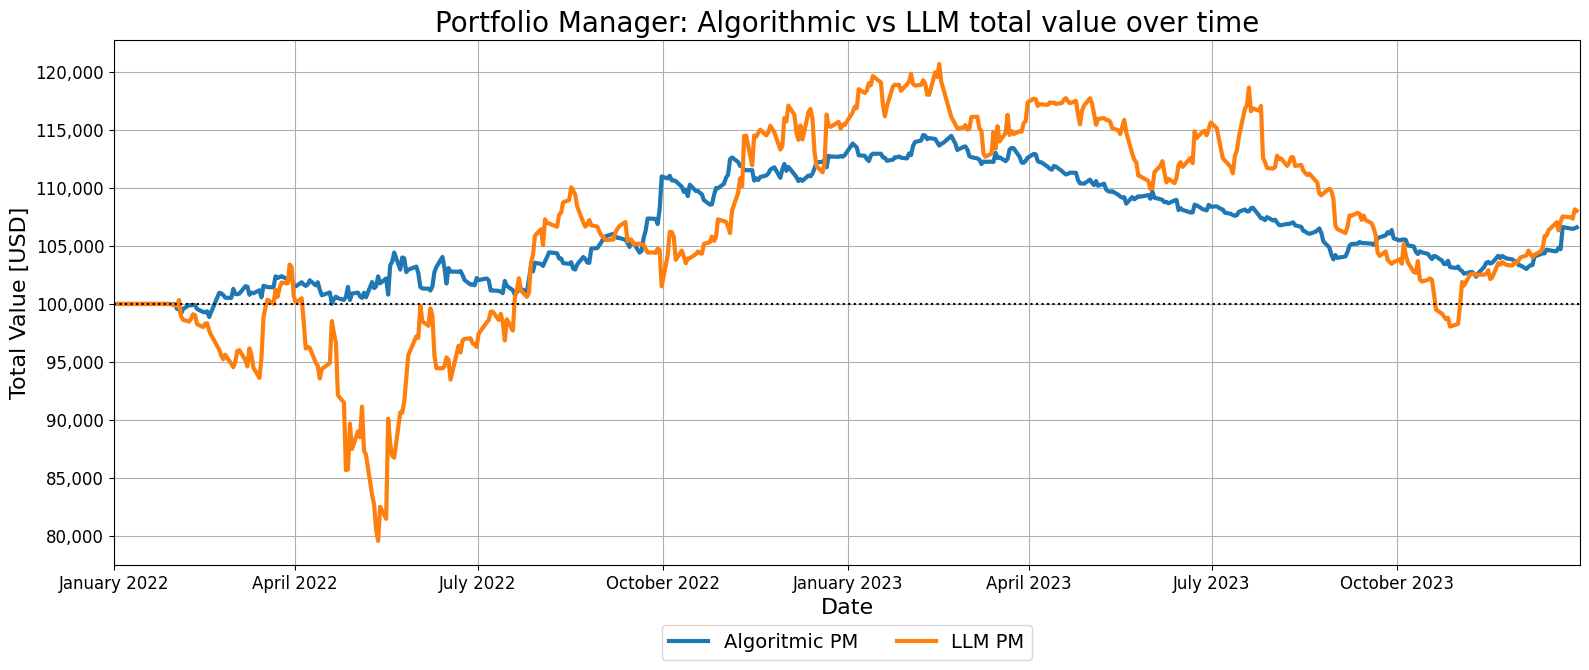

In [4]:
import matplotlib.dates as mdates
import matplotlib as mpl

simulation_date_documents = SimulationDate.objects(simulation_id=simulation_id, pm_llm_eod_total_val__ne=None)
df = pd.DataFrame.from_records(simulation_date_documents.values_list("date", "pm_algo_eod_total_val", "pm_llm_eod_total_val"), columns=["Date", "PM Algo Total Value", "PM LLM Total Value"])

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

print(df.tail(5))

# Plot the data
fig = plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['PM Algo Total Value'], label='Algoritmic PM', linewidth=3)
plt.plot(df['Date'], df['PM LLM Total Value'], label='LLM PM', linewidth=3)
plt.title('Portfolio Manager: Algorithmic vs LLM total value over time', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Value [USD]', fontsize=16)
plt.legend(fontsize=14, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.grid(True)
plt.xticks(rotation=360, fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([datetime(2022, 1, 1), datetime(2023, 12, 31)])
plt.axhline(100000, color='black', linestyle='dotted')  # Add horizontal dotted line at quantity = 0

# Set x-axis major formatter to show full month name and year
locator = mdates.MonthLocator(interval=3)
formatter = mdates.DateFormatter('%B %Y')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Set y-axis major locator to have ticks every 5000 units
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5000))

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)  # Add space to the bottom
plt.show()

### Positions

In [6]:
import seaborn as sns
from matplotlib.ticker import MultipleLocator

simulation_date_documents = SimulationDate.objects(simulation_id=simulation_id, pm_llm_eod_total_val__ne=None)
df_algo = pd.DataFrame(columns=["Date", "Quantity", "Symbol", "Value", "Price"])
df_llm = pd.DataFrame(columns=["Date", "Quantity", "Symbol", "Value", "Price"])
df_combined = pd.DataFrame.from_records(simulation_date_documents.values_list("date", "pm_algo_eod_total_val", "pm_llm_eod_total_val"), columns=["Date", "PM Algo Total Value", "PM LLM Total Value"])

for simulation_date in simulation_date_documents:
    # Cash
    new_row = {"Date": simulation_date.date, "Quantity": 1, "Symbol": "Cash", "Value": simulation_date.pm_algo_eod_cash, "Price": simulation_date.pm_algo_eod_cash}
    df_algo = pd.concat([df_algo, pd.DataFrame([new_row])], ignore_index=True)
    new_row = {"Date": simulation_date.date, "Quantity": 1, "Symbol": "Cash", "Value": simulation_date.pm_llm_eod_cash, "Price": simulation_date.pm_llm_eod_cash}
    df_llm = pd.concat([df_llm, pd.DataFrame([new_row])], ignore_index=True)
    # Positions
    for pos in simulation_date.pm_algo_eod_positions:
        price = PolygonAggregates.objects(ticker=pos.ticker, timestamp__lt=simulation_date.date).order_by("-timestamp").first().close
        new_row = {"Date": simulation_date.date, "Quantity": pos.quantity, "Symbol": pos.ticker, "Value": price * pos.quantity, "Price": price}
        df_algo = pd.concat([df_algo, pd.DataFrame([new_row])], ignore_index=True)        
    for pos in simulation_date.pm_llm_eod_positions:
        price = PolygonAggregates.objects(ticker=pos.ticker, timestamp__lt=simulation_date.date).order_by("-timestamp").first().close
        new_row = {"Date": simulation_date.date, "Quantity": pos.quantity, "Symbol": pos.ticker, "Value": price * pos.quantity, "Price": price}
        df_llm = pd.concat([df_llm, pd.DataFrame([new_row])], ignore_index=True) 


C:\Users\micha\AppData\Local\Temp\ipykernel_7104\620957553.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_algo = pd.concat([df_algo, pd.DataFrame([new_row])], ignore_index=True)
C:\Users\micha\AppData\Local\Temp\ipykernel_7104\620957553.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_llm = pd.concat([df_llm, pd.DataFrame([new_row])], ignore_index=True)


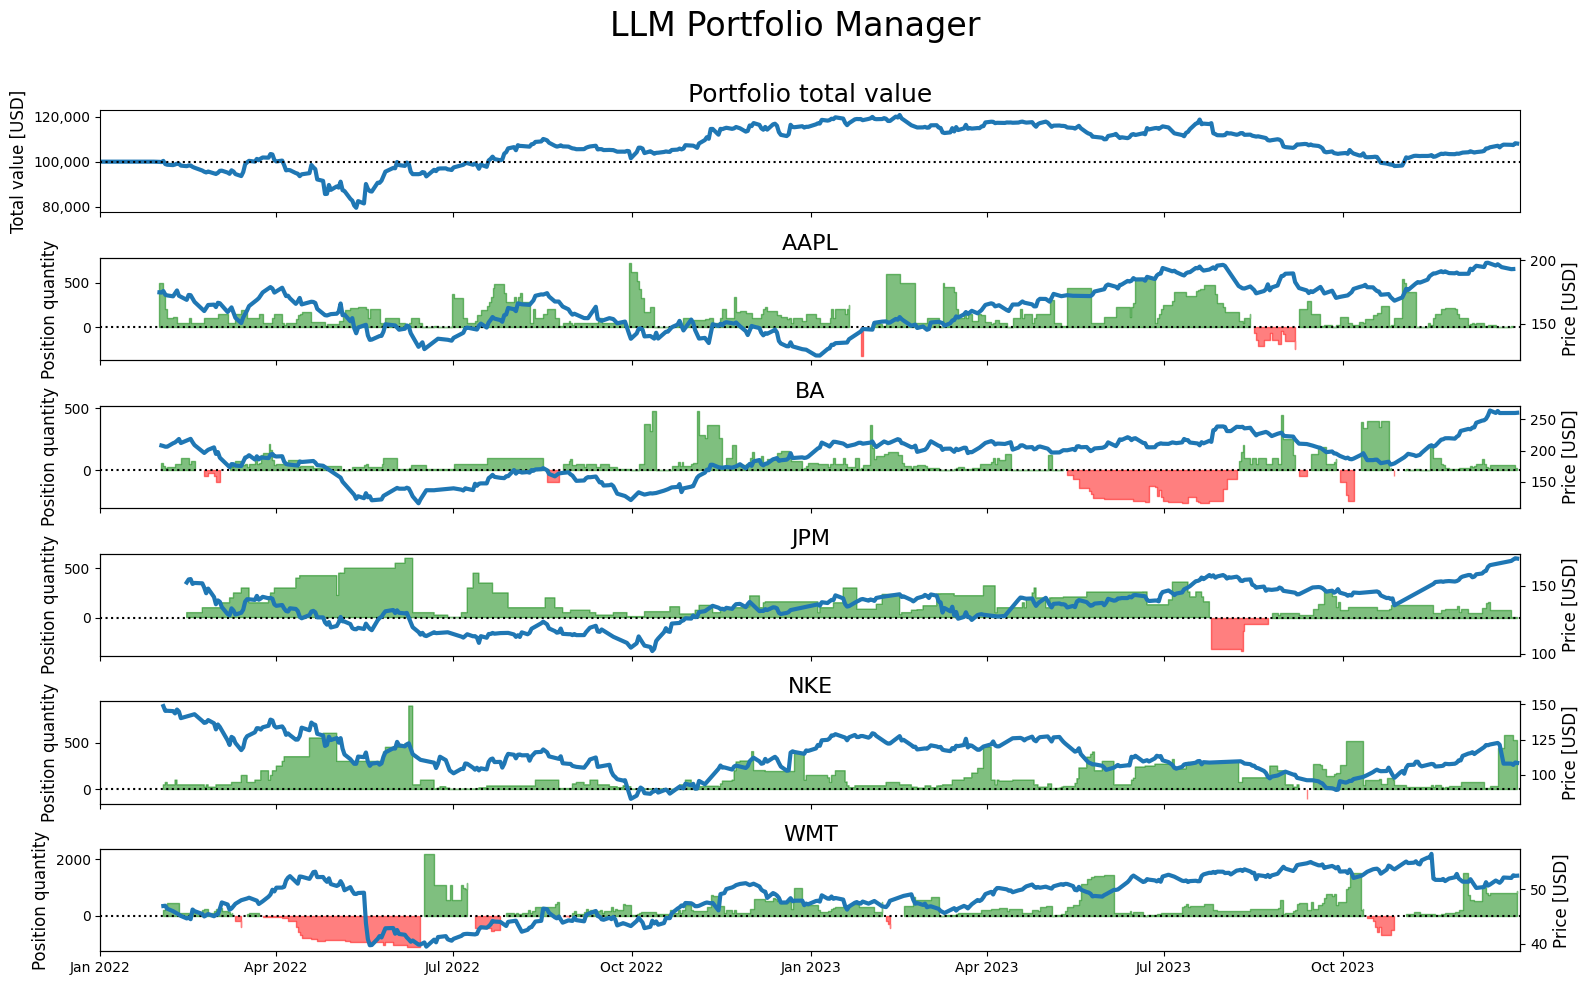

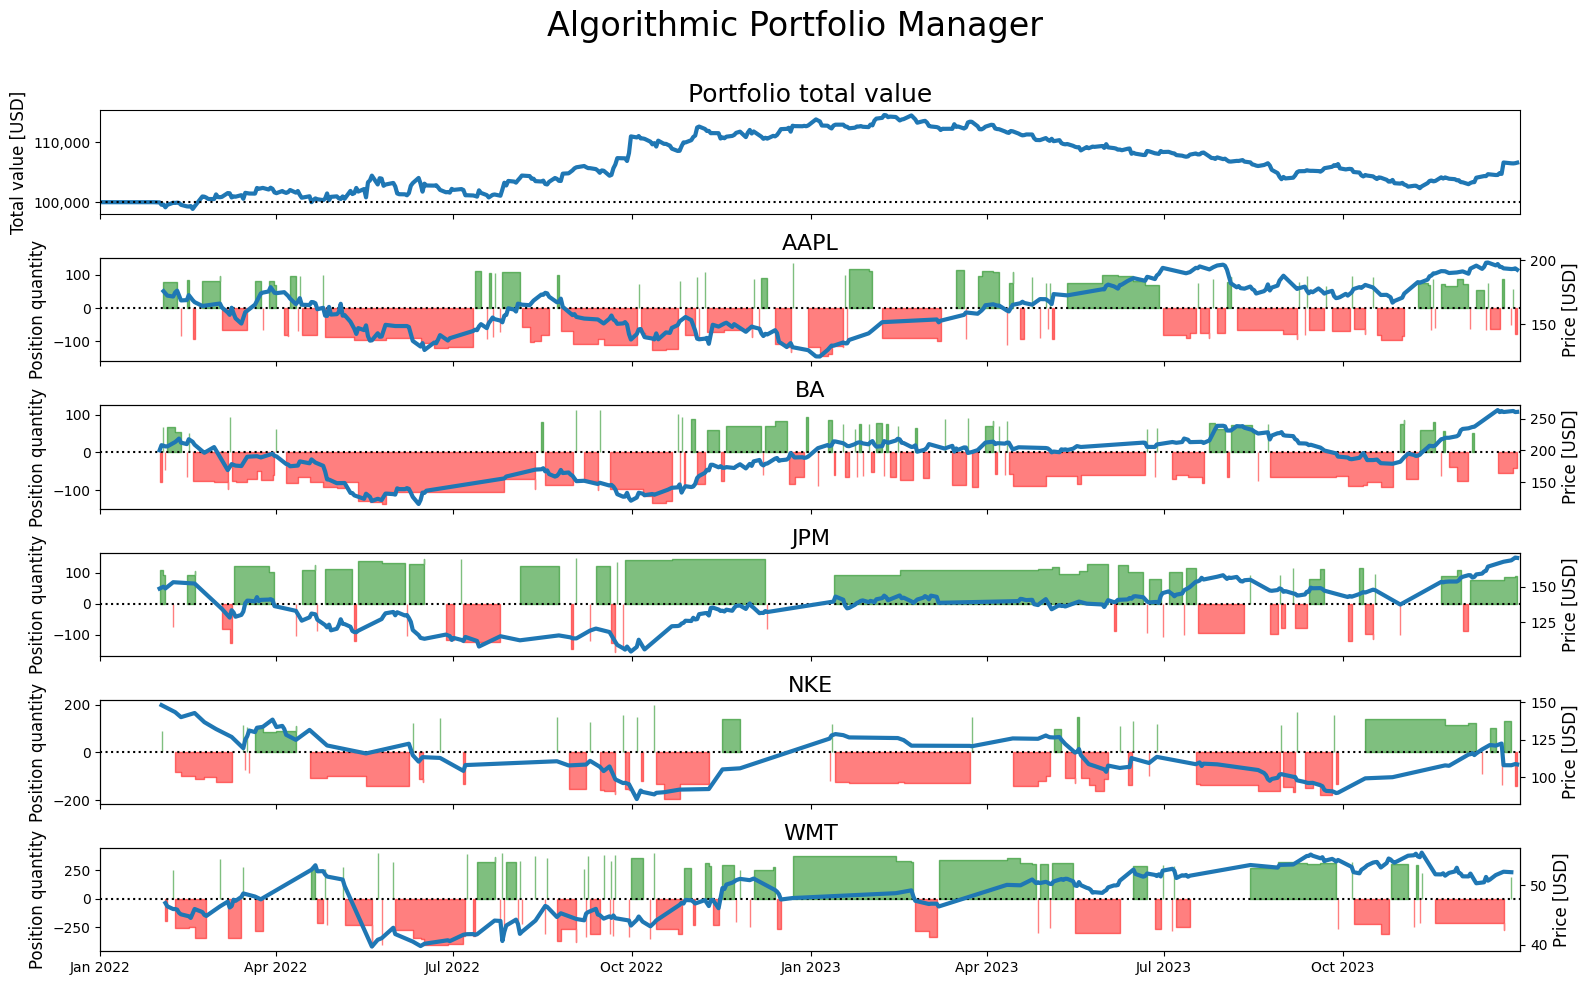

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_df(df, title: str, df_combined_row: str):
    # Ensure 'Date' is in datetime format and 'Quantity' and 'Price' are numeric
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

    # Remove rows with NaN values in any of the critical columns
    df = df.dropna(subset=['Date', 'Quantity', 'Price'])

    # Set the date range for the x-axis
    start_date = pd.to_datetime('2022-01-01')
    end_date = pd.to_datetime('2023-12-31')

    tickers_list = list(df["Symbol"].unique())
    if "Cash" in tickers_list:
        tickers_list.remove("Cash")
    tickers_list.sort()
    fig, axes = plt.subplots(len(tickers_list)+1, 1, figsize=(16, 10), sharex=True)  # Create a grid of subplots with shared x-axis
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Plot total value
    axes[0].set_title("Portfolio total value", fontsize=18)
    axes[0].plot(df_combined["Date"], df_combined[df_combined_row], linewidth=3)
    axes[0].set_ylabel('Total value [USD]', fontsize=12)  # Increase y-axis label font size
    axes[0].axhline(100000, color='black', linestyle='dotted')  # Add horizontal dotted line at quantity = 0
    axes[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    for i, ticker in enumerate(tickers_list):
        i=i+1
        ticker_df = df[df["Symbol"] == ticker]
        # Left axis
        axes[i].set_title(ticker, fontsize=16)  # Increase subtitle font size
        # axes[i].plot(ticker_df["Date"], ticker_df["Quantity"])
        axes[i].set_ylabel('Position quantity', fontsize=12)  # Increase y-axis label font size
        axes[i].fill_between(ticker_df["Date"], 0, ticker_df["Quantity"], where=ticker_df["Quantity"] > 0, color='green', alpha=0.5, step="post")
        axes[i].fill_between(ticker_df["Date"], 0, ticker_df["Quantity"], where=ticker_df["Quantity"] < 0, color='red', alpha=0.5, step="post")
        axes[i].axhline(0, color='black', linestyle='dotted')  # Add horizontal dotted line at quantity = 0

        # Set x-axis limits
        axes[i].set_xlim([start_date, end_date])

        # Right axis
        ax_price = axes[i].twinx()
        ax_price.plot(ticker_df["Date"], ticker_df["Price"], linewidth=3)
        ax_price.set_ylabel('Price [USD]', fontsize=12)  # Increase y-axis label font size

        locator = mdates.MonthLocator(interval=3)
        formatter = mdates.DateFormatter('%b %Y')
        axes[i] = plt.gca()
        axes[i].xaxis.set_major_locator(locator)
        axes[i].xaxis.set_major_formatter(formatter)

    # Set a title for the entire plot
    fig.suptitle(title, fontsize=24)

    # Increase font size for x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', labelsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the main title
    plt.show()


plot_df(df_llm, title="LLM Portfolio Manager", df_combined_row="PM LLM Total Value")
plot_df(df_algo, title="Algorithmic Portfolio Manager", df_combined_row="PM Algo Total Value")
